In [1248]:
import pandas as pd

file = 'Foodex_2_L7_dashboard.xlsx'

data = pd.read_excel(file, skiprows=2)
EU_df = pd.DataFrame(data)


C:\Users\97258\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [1249]:
EU_df

,Survey's country,Survey start year,Survey name,Population Group (L2),Exposure hierarchy (L1),Exposure hierarchy (L2),Exposure hierarchy (L3),Exposure hierarchy (L4),Exposure hierarchy (L5),Exposure hierarchy (L6),...,Number of consumers,Mean,Standard Deviation,5th percentile,10th percentile,Median,95th percentile,97.5th percentile,99th percentile,Comment
0,Austria,2010,Austrian Study on Nutritional Status 2010-12 -...,Adults,Alcoholic beverages,Beer and beer-like beverage,Beer,Beer,Beer,Beer,...,71,96.801948,250.225468,0.0,0.0,0.000000,500.000000,750.000000,1000.000000,NaN
1,Austria,2010,Austrian Study on Nutritional Status 2010-12 -...,Adults,Alcoholic beverages,Beer and beer-like beverage,Beer,Lager beer,"Beer, alcohol-free","Beer, alcohol-free",...,1,0.405844,7.122536,0.0,0.0,0.000000,0.000000,0.000000,0.000000,NaN
2,Austria,2010,Austrian Study on Nutritional Status 2010-12 -...,Adults,Alcoholic beverages,Beer and beer-like beverage,Beer,Lager beer,"Beer, regular","Beer, regular",...,3,1.477273,15.035554,0.0,0.0,0.000000,0.000000,0.000000,0.000000,NaN
3,Austria,2010,Austrian Study on Nutritional Status 2010-12 -...,Adults,Alcoholic beverages,Beer and beer-like beverage,Beer-like beverages,Mixed beer drinks,Mixed beer drinks,Mixed beer drinks,...,17,19.529221,94.652747,0.0,0.0,0.000000,165.000000,250.000000,637.647059,NaN
4,Austria,2010,Austrian Study on Nutritional Status 2010-12 -...,Adults,Alcoholic beverages,Mixed alcoholic drinks,Other mixed alcoholic drinks,Punch,Punch,Punch,...,2,0.649351,8.045095,0.0,0.0,0.000000,0.000000,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99888,United Kingdom,2011,Diet and Nutrition Survey of Infants and Young...,Toddlers,Water and water-based beverages,Water based beverages,Soft drinks,Soft drinks with minor amounts of fruits or fl...,"Soft drink, flavoured, no fruit","Soft drink, flavoured, no fruit",...,5,0.136377,2.703368,0.0,0.0,0.000000,0.000000,0.000000,0.000000,NaN
99889,United Kingdom,2011,Diet and Nutrition Survey of Infants and Young...,Toddlers,Water and water-based beverages,Water based beverages,Soft drinks,Soft drinks with minor amounts of fruits or fl...,"Soft drink, flavoured, no fruit","Soft drink, lemon flavour",...,2,0.004949,0.179315,0.0,0.0,0.000000,0.000000,0.000000,0.000000,NaN
99890,United Kingdom,2011,Diet and Nutrition Survey of Infants and Young...,Toddlers,Water and water-based beverages,Water based beverages,Soft drinks,Soft drinks with minor amounts of fruits or fl...,"Soft drink, flavoured, no fruit","Soft drink, mixed flavours",...,2,0.014555,0.380323,0.0,0.0,0.000000,0.000000,0.000000,0.000000,NaN
99891,United Kingdom,2011,Diet and Nutrition Survey of Infants and Young...,Toddlers,Water and water-based beverages,Water based beverages,Soft drinks,Soft drinks with minor amounts of fruits or fl...,"Soft drink, with fruit juice (fruit content be...","Fruit soft drink, mixed fruit",...,27,1.449822,15.928171,0.0,0.0,0.000000,0.000000,0.000000,47.060000,NaN


In [1250]:
EU_df = EU_df[['Survey\'s country', 'Survey start year', 'Survey name',
       'Population Group (L2)', 'Exposure hierarchy (L1)',
       'Exposure hierarchy (L2)', 'Exposure hierarchy (L3)',
       'Exposure hierarchy (L4)', 'Exposure hierarchy (L5)',
       'Exposure hierarchy (L6)', 'Exposure hierarchy (L7)',
       'Number of subjects', 'Number of consumers', 'Mean']]

In [1251]:
# I want to filter out non-adults out of the DF.

filtered_surveys = EU_df[EU_df['Population Group (L2)']=='Adults']


In [1252]:
# Because there are multiple years in which survey were conducted, I wanted to take the most recent year only for each age cohort.

most_recent_yr = filtered_surveys.groupby('Survey\'s country')['Survey start year'].max()
most_recent_yr = most_recent_yr.reset_index()

In [1254]:
# Filter the main dataframe by the most recent year for each country and age cohort.

criteria = most_recent_yr[['Survey\'s country','Survey start year']].values.tolist()

filtered_surveys['Match'] = False # Default is False for this new column

for index, row in  filtered_surveys.iterrows():
    for cr in criteria:
        if (row['Survey\'s country'] == cr[0]
                and row['Survey start year'] == cr[1]):
             filtered_surveys.at[index, 'Match'] = True # If the df row falls w/in the criteria, change the default to True


<ipython-input-1254-b1874638522c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_surveys['Match'] = False # Default is False for this new column


In [1255]:
recent_surveys = filtered_surveys[filtered_surveys['Match']==True]

In [1256]:
surveys_post_2012 = recent_surveys[recent_surveys['Survey start year']>2012]


In [1257]:
final_df = surveys_post_2012[['Survey\'s country', 'Survey start year', 'Survey name',
       'Population Group (L2)', 'Exposure hierarchy (L1)',
       'Exposure hierarchy (L2)', 'Exposure hierarchy (L3)',
       'Exposure hierarchy (L4)', 'Exposure hierarchy (L5)',
       'Exposure hierarchy (L6)', 'Exposure hierarchy (L7)',
       'Number of subjects', 'Number of consumers', 'Mean']]

In [1258]:
# There is no column showing total grams of consumption for each row, but I can create it using other data

final_df['Total grams'] = final_df['Mean'] * final_df['Number of subjects']

In [1259]:
# I want two dfs, one w/ alcoholic beverages and one with food only

beverage_df = final_df[final_df['Exposure hierarchy (L1)'].str.contains('beverage', case=False)]

food_df = final_df[~final_df['Exposure hierarchy (L1)'].str.contains('beverage', case=False)]


In [1260]:
# Food data cleaning
food_df = food_df[~food_df['Exposure hierarchy (L1)'].str.contains('tea',case=False)]
food_df = food_df[food_df['Exposure hierarchy (L2)'] != 'Milk and dairy powders and concentrates']

In [1261]:
# Filter the food dataframe by the total food intake by country as the denoinator in my percentage calc

criteria_food = food_df[['Survey\'s country', 'Total grams']].values.tolist()

criteria_food_dict = {row[0]: row[1] for row in criteria_food}

# Assign Total consumed value to a new column by country
food_df['Total consumed'] = food_df['Survey\'s country'].map(criteria_dict)

In [1262]:
# I want to have a column showing how much of each row is as a percentage of the total

food_df['Percent'] = food_df['Total grams']/food_df['Total consumed']
food_df['Percent']=food_df['Percent']*100

#  Who are the biggest pasta lovers?

In [1263]:
# I want to do analysis of pasta specifically

pasta_doughs_df =  food_df[food_df['Exposure hierarchy (L2)']=='Pasta, doughs and similar products']

pasta_df = pasta_doughs_df[pasta_doughs_df['Exposure hierarchy (L3)'].str.contains('pasta',case=False)]

In [1264]:
pasta_sum =  pasta_df.groupby('Survey\'s country')['Percent'].sum().reset_index()

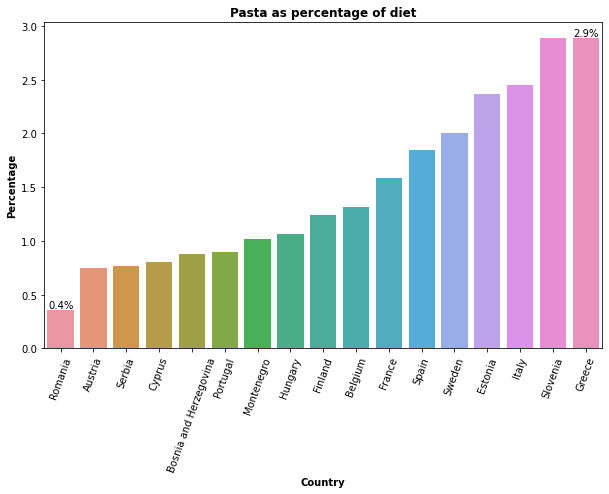

In [1266]:
# Displays biggest pasta consumers

import seaborn as sns 

sorted_pasta_sum = pasta_sum.sort_values(by='Percent', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Survey\'s country', y='Percent', data=sorted_pasta_sum)
plt.title('Pasta as percentage of diet',fontweight='bold')
plt.xticks(rotation=70) 
plt.xlabel('Country',fontweight='bold')
plt.ylabel('Percentage',fontweight='bold')

# Mark the highest and lowest bar with its percentage value
highest_value = sorted_pasta_sum['Percent'].iloc[-1]
plt.text(len(sorted_pasta_sum) - 1, highest_value, f'{highest_value:.1f}%', ha='center', va='bottom', fontsize=10)

lowest_value = sorted_pasta_sum['Percent'].iloc[0]
plt.text(0, lowest_value, f'{lowest_value:.1f}%', ha='center', va='bottom', fontsize=10)

plt.show()

# Who eats the weirdest foods?

In [1267]:
weird_food =  food_df[food_df['Exposure hierarchy (L2)']=='Amphibians, reptiles, snails, insects']

weird_food['Exposure hierarchy (L4)'].unique()

array(['Frogs meat', 'Snails'], dtype=object)

In [1268]:
frog_df = weird_food[weird_food['Exposure hierarchy (L4)']=='Frogs meat']

In [1269]:
snail_df = weird_food[weird_food['Exposure hierarchy (L4)']=='Snails']

In [1270]:
frog_sum =  frog_df.groupby('Survey\'s country')['Percent'].sum().reset_index()
snail_sum =  snail_df.groupby('Survey\'s country')['Percent'].sum().reset_index()


<Figure size 864x432 with 0 Axes>

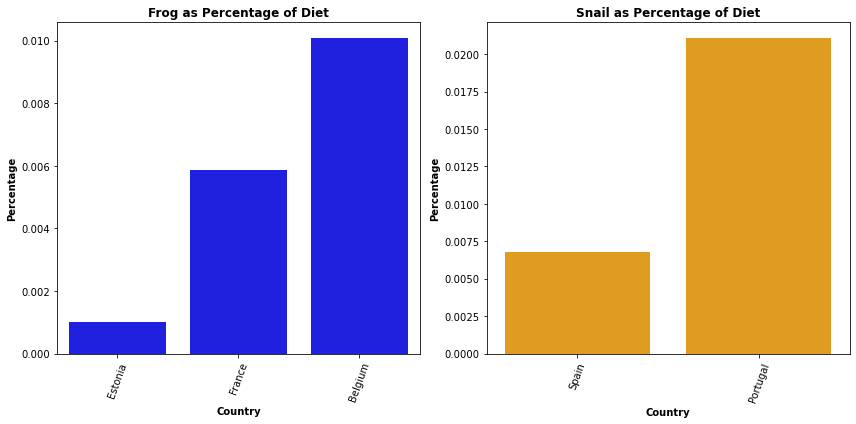

In [1271]:
plt.figure(figsize=(12, 6))

# I want in order from smallest to largest consumers
sorted_frog_sum = frog_sum.sort_values(by='Percent')
sorted_snail_df = snail_df.sort_values(by='Percent')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Survey\'s country', y='Percent', data=sorted_frog_sum, color='blue')
plt.title('Frog as Percentage of Diet',fontweight='bold')
plt.xlabel('Country',fontweight='bold')
plt.ylabel('Percentage',fontweight='bold')
plt.xticks(rotation=70)
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.barplot(x='Survey\'s country', y='Percent', data=sorted_snail_df, color='orange')
plt.title('Snail as Percentage of Diet',fontweight='bold')
plt.xlabel('Country',fontweight='bold')
plt.ylabel('Percentage',fontweight='bold')
plt.xticks(rotation=70)
plt.tight_layout()


# Where's the beef!?!

In [1272]:
meats_df = food_df[food_df['Exposure hierarchy (L1)']=='Meat and meat products']

# I want to see beef specifically
beef_df = meats_df[meats_df['Exposure hierarchy (L4)'].str.contains('beef|bovine',case=False)]

In [1273]:
beef_sum =  beef_df.groupby('Survey\'s country')['Percent'].sum().reset_index()

In [1297]:
beef_sum

,Survey's country,Percent
0,Austria,1.739031
1,Belgium,3.535782
2,Bosnia and Herzegovina,4.440372
3,Cyprus,0.361027
4,Estonia,3.044414
5,Finland,2.129594
6,France,3.674988
7,Greece,5.655873
8,Hungary,0.518895
9,Italy,2.770123


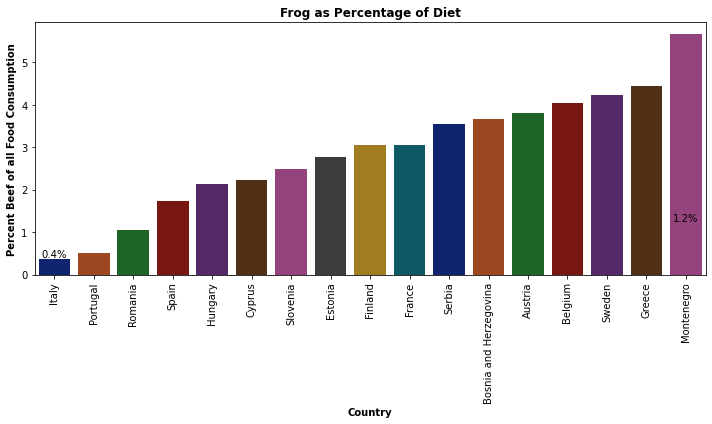

In [1307]:
sorted_beef_sum = beef_sum.sort_values(by='Percent')

plt.figure(figsize=(10, 6))
sns.barplot(x='Survey\'s country', y='Percent', data=sorted_beef_sum, palette='dark')
plt.title('Frog as Percentage of Diet',fontweight='bold')
plt.xlabel('Country',fontweight='bold')
plt.ylabel('Percentage',fontweight='bold')
plt.xticks(rotation=70)
plt.tight_layout()

plt.xlabel('Percent Beef Consumption')
plt.ylabel('Frequency')
plt.xlabel('Country')
plt.ylabel('Percent Beef of all Food Consumption')

plt.xticks(range(len(sorted_choc_sum)), sorted_choc_sum['Survey\'s country'], rotation=90)
plt.tight_layout()

lowest_value = sorted_choc_sum['Percent'].iloc[0]
plt.text(0, lowest_value, f'{lowest_value:.1f}%', ha='center', va='bottom', fontsize=10)

highest_value = sorted_choc_sum['Percent'].iloc[-1]
plt.text(len(sorted_choc_sum) - 1, highest_value, f'{highest_value:.1f}%', ha='center', va='bottom', fontsize=10)

plt.show()


# Non-water based beverages

In [1308]:
# Filter the main dataframe by the total beverage intake by country

criteria_bev = total_bev[['Survey\'s country', 'Total grams']].values.tolist()

# Create a dictionary 
criteria_dict = {row[0]: row[1] for row in criteria_bev}

# Assign Total consumed value to a new column by country
beverage_df['Total consumed'] = beverage_df['Survey\'s country'].map(criteria_dict)

<ipython-input-1308-3ed2557dcce7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beverage_df['Total consumed'] = beverage_df['Survey\'s country'].map(criteria_dict)


In [1309]:
beverage_df['Percent'] = beverage_df['Total grams']/beverage_df['Total consumed']
beverage_df['Percent']=beverage_df['Percent']*100


<ipython-input-1309-5b0e4fcb466c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beverage_df['Percent'] = beverage_df['Total grams']/beverage_df['Total consumed']
<ipython-input-1309-5b0e4fcb466c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beverage_df['Percent']=beverage_df['Percent']*100


In [1310]:
# I want to see what people drink other than water

nonwater_df = beverage_df[~beverage_df['Exposure hierarchy (L2)'].str.contains('water',case=False)]

nonwater_perc = nonwater_df.groupby(['Survey\'s country','Exposure hierarchy (L2)'])['Percent'].sum().reset_index()

In [1311]:
nonwater_perc_total = nonwater_perc.groupby(['Survey\'s country'])['Percent'].sum().reset_index()


In [1312]:
# I want to take the percentages of only non-water beverages as percent of non-water beverages

criteria_alc_tot = nonwater_perc_total[['Survey\'s country', 'Percent']].values.tolist()
 
criteria_alc_tot_dict = {row[0]: row[1] for row in criteria_alc_tot}

nonwater_perc['Functional perc total'] = nonwater_perc['Survey\'s country'].map(criteria_alc_tot_dict)

In [1313]:
nonwater_perc['Functional perc']=nonwater_perc['Percent']/nonwater_perc['Functional perc total']
nonwater_perc['Functional perc']=nonwater_perc['Functional perc']*100

# Cheers!

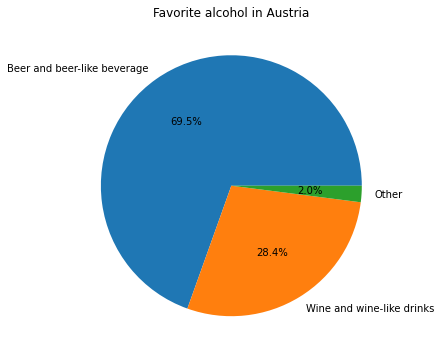

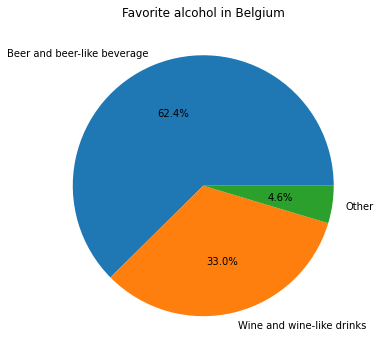

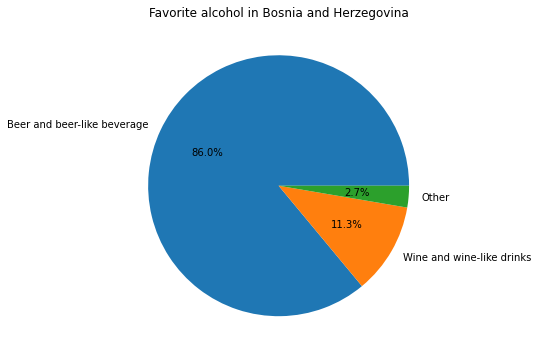

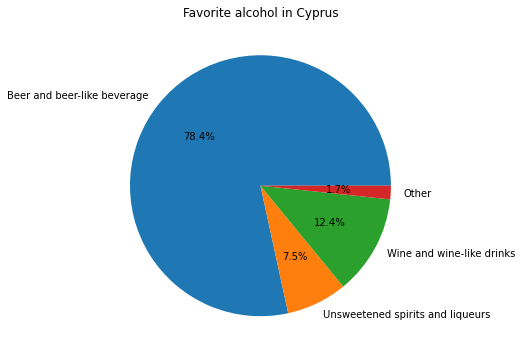

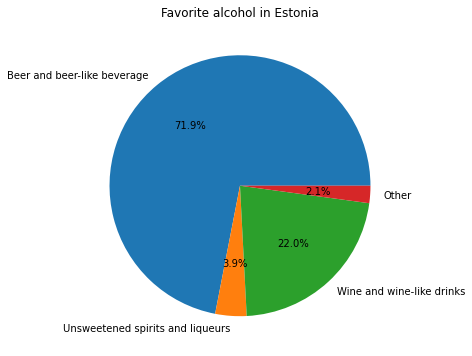

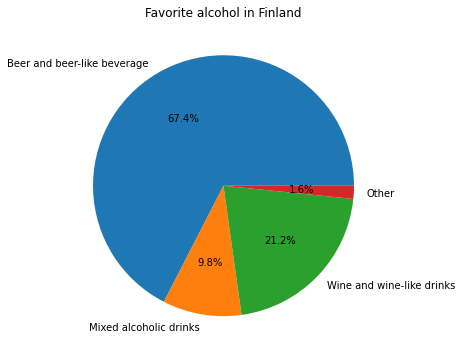

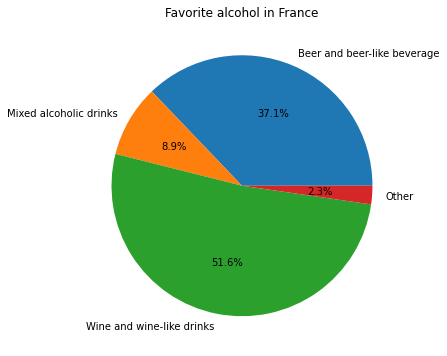

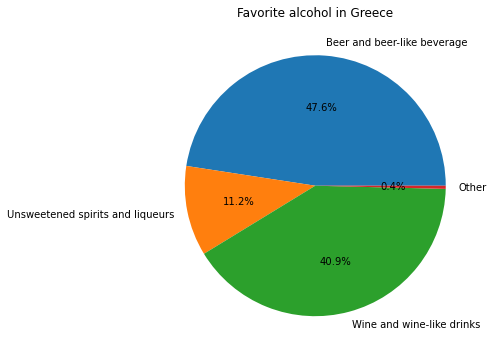

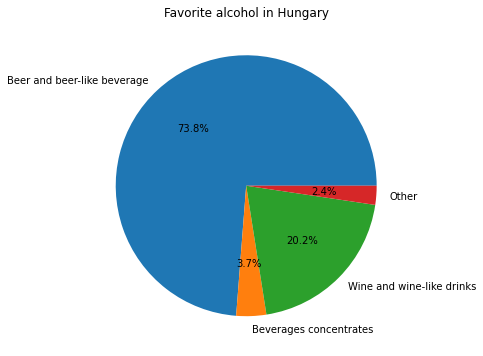

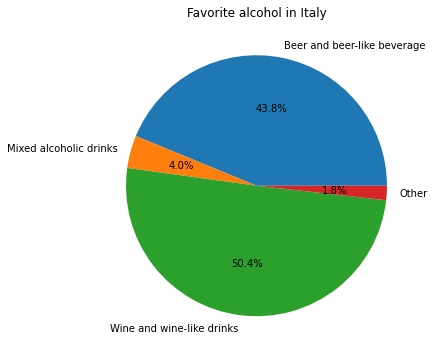

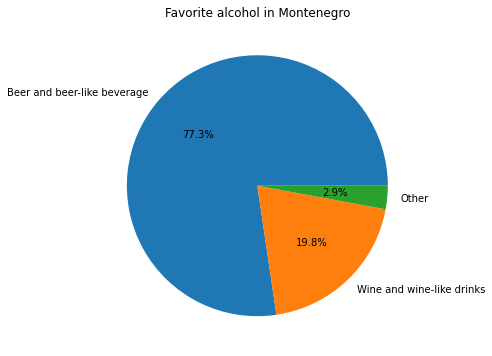

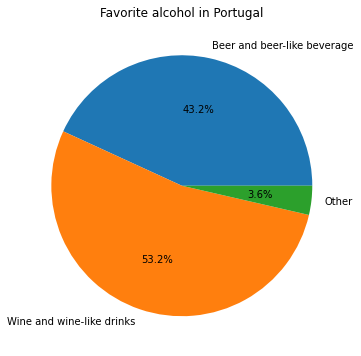

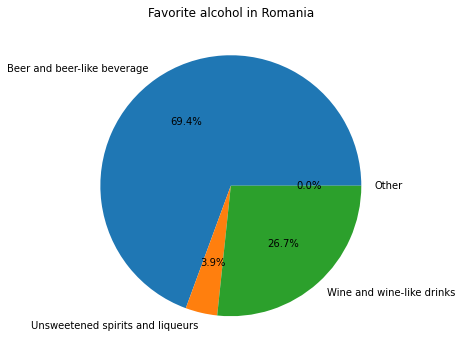

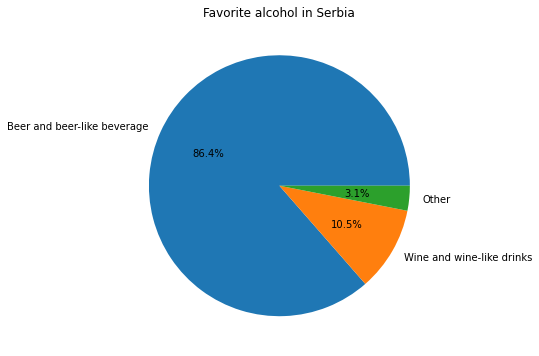

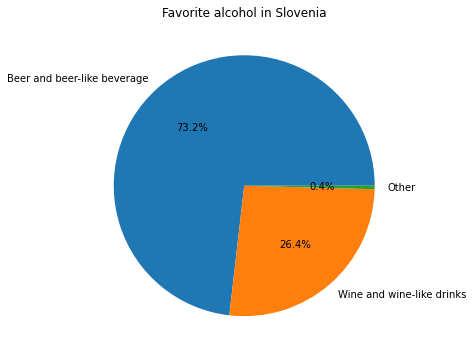

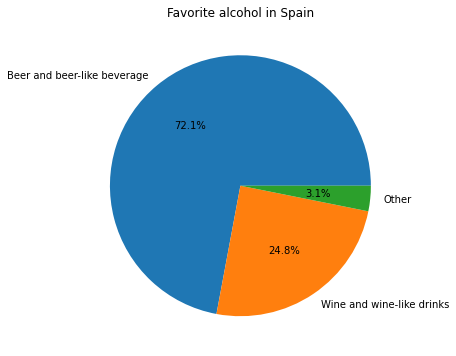

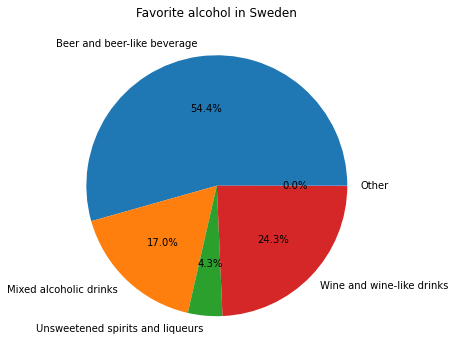


The country that loves Beer the most is Serbia! With 86.4 of its non-water beverage consumption, 
Serbia loves this hoppy fizzy bar favourite 

The country that loves Wine the most is Portugal! With 53.2 of its non-water beverage consumption,
Portugal loves this elegant and complex symbol of status


In [1314]:
import matplotlib.pyplot as plt

# Get unique countries in the DataFrame
unique_countries = nonwater_perc['Survey\'s country'].unique()

# Filter DF for each unique country and create pie charts
for c in unique_countries:
    country_data = nonwater_perc[nonwater_perc['Survey\'s country'] == c]
    group_data = country_data.groupby('Exposure hierarchy (L2)')['Functional perc'].sum()

    # Group small values into 'Other' category
    other_data = group_data[group_data > 3]
    other_data['Other'] = group_data[group_data < 3].sum()

    plt.figure(figsize=(8, 6))
    plt.pie(other_data, labels=other_data.index, autopct='%1.1f%%')
    plt.title(f'Favorite alcohol in {c}')
    plt.show()
    
    if 'Beer and beer-like beverage' in other_data and other_data['Beer and beer-like beverage'] > largest_beer_slice:
        largest_beer_slice = other_data['Beer and beer-like beverage']
        largest_beer_country = c

    if 'Wine and wine-like drinks' in other_data and other_data['Wine and wine-like drinks'] > largest_wine_slice:
        largest_wine_slice = other_data['Wine and wine-like drinks']
        largest_wine_country = c
        
print(f'''
The country that loves Beer the most is {largest_beer_country}! With {largest_beer_slice:.1f} of its non-water beverage consumption, 
{largest_beer_country} loves this hoppy fizzy bar favourite \n
The country that loves Wine the most is {largest_wine_country}! With {largest_wine_slice:.1f} of its non-water beverage consumption,
{largest_wine_country} loves this elegant and complex symbol of status''')
        

In [1315]:
wine_perc = nonwater_perc[nonwater_perc['Exposure hierarchy (L2)'].str.contains('wine',case=False)]

In [1316]:
wine_df = wine_perc[['Survey\'s country','Functional perc']]

In [1323]:
merged_df

,Country,Wine Percent,Beef Percent
0,Austria,28.441927,1.739031
1,Belgium,32.953255,3.535782
2,Bosnia and Herzegovina,11.290769,4.440372
3,Cyprus,12.384341,0.361027
4,Estonia,22.036201,3.044414
5,Finland,21.171530,2.129594
6,France,51.635360,3.674988
7,Greece,40.874007,5.655873
8,Hungary,20.164194,0.518895
9,Italy,50.395660,2.770123


# How does beef and wine go together?

In [1318]:
merged_df = pd.merge(wine_df, beef_sum, on='Survey\'s country')

column_mapping = {
    'Survey\'s country': 'Country',
    'Functional perc': 'Wine Percent',
    'Percent': 'Beef Percent'
}

# Rename columns in the DataFrame
merged_df = merged_df.rename(columns=column_mapping)

plt.figure(figsize=(8, 6))
scatterplot = sns.scatterplot(x='Wine Percentage', y='Beef Percentage', data=merged_df)
sns.regplot(x='Wine Percen', y='Beef Percentage', data=merged_df, scatter=False, ax=scatterplot)
scatterplot.set_title('Scatterplot with Correlation Line', fontweight='bold')
plt.show()


ValueError: Could not interpret value `Wine Percentage` for parameter `x`

<Figure size 576x432 with 0 Axes>

In [ ]:
choc_df = food_df[food_df['Exposure hierarchy (L4)'].str.contains('chocolate',case=False)]

In [ ]:
choc_sum =  choc_df.groupby('Survey\'s country')['Percent'].sum().reset_index()

# Saving the sweetest for last

In [ ]:
sorted_choc_sum = choc_sum.sort_values(by='Percent', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Survey\'s country', y='Percent', data=sorted_choc_sum)
plt.title('Chocolate as percentage of diet',fontweight='bold')
plt.xticks(rotation=70) 
plt.xlabel('Country',fontweight='bold')
plt.ylabel('Percentage',fontweight='bold')

# Mark the highest and lowest bar with its percentage value
highest_value = sorted_choc_sum['Percent'].iloc[-1]
plt.text(len(sorted_choc_sum) - 1, highest_value, f'{highest_value:.1f}%', ha='center', va='bottom', fontsize=10)

lowest_value = sorted_choc_sum['Percent'].iloc[0]
plt.text(0, lowest_value, f'{lowest_value:.1f}%', ha='center', va='bottom', fontsize=10)

plt.show()

# Waffles are from Belgium

In [ ]:
baked = food_df[food_df['Exposure hierarchy (L2)'].str.contains('fine bakery wares',case=False)]

In [ ]:
# Adding total baked goods column as denominator in % calc

baked_total = baked.groupby('Survey\'s country')['Total grams'].sum().reset_index()
            
criteria_baked = baked_total[['Survey\'s country', 'Total grams']].values.tolist()

criteria_baked_dict = {row[0]: row[1] for row in criteria_baked}

# Assign Total baked goods consumed value to a new column by country
baked['Total baked goods consumed'] = baked['Survey\'s country'].map(criteria_baked_dict)              

In [ ]:
baked['As perc of baked goods'] = baked['Total grams']/baked['Total baked goods consumed']

In [ ]:
baked['As perc of baked goods']=baked['As perc of baked goods']*100

In [ ]:
waffles = baked[baked['Exposure hierarchy (L4)'].str.contains('waffle',case=False)]

In [ ]:
waffles_sum =  waffles.groupby('Survey\'s country')['As perc of baked goods'].sum().reset_index()

In [ ]:
sorted_waffle = waffles_sum.sort_values(by='As perc of baked goods', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Survey\'s country', y='As perc of baked goods', data=sorted_waffle)
plt.title('Waffles as percentage of baked goods consumed',fontweight='bold')
plt.xticks(rotation=70) 
plt.xlabel('Country',fontweight='bold')
plt.ylabel('Percentage',fontweight='bold')

# Mark the highest and lowest bar with its percentage value
highest_value = sorted_waffle['As perc of baked goods'].iloc[-1]
plt.text(len(sorted_waffle) - 1, highest_value, f'{highest_value:.1f}%', ha='center', va='bottom', fontsize=10)

lowest_value = sorted_waffle['As perc of baked goods'].iloc[0]
plt.text(0, lowest_value, f'{lowest_value:.1f}%', ha='center', va='bottom', fontsize=10)

plt.show()